In [1]:
import logging
import os
import shutil
import sys
import tempfile
import glob

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import CacheDataset, NiftiDataset, create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, NormalizeIntensityd, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandSpatialCropd, RandAffined, Spacingd, Orientationd, ToTensord
from monai.visualize import plot_2d_or_3d_image

from torch import nn
monai.config.print_config()

from typing import Optional, Union

import warnings

from monai.networks import one_hot
from monai.utils import MetricReduction

MONAI version: 0.1.0+715.gf777a25.dirty
Python version: 3.7.4 (default, Jul 18 2019, 19:34:02)  [GCC 5.4.0]
Numpy version: 1.18.1
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.16.2
Pillow version: 7.1.0
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
class CrossentropyND(torch.nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)
    
class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.):
        """
        """
        super(SoftDiceLoss, self).__init__()

        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn, _ = get_tp_fp_fn_tn(x, y, axes, loss_mask, False)

        nominator = 2 * tp + self.smooth
        denominator = 2 * tp + fp + fn + self.smooth

        dc = nominator / denominator

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc
    
def get_tp_fp_fn_tn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes: can be (, ) = no summation
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot
    tn = (1 - net_output) * (1 - y_onehot)

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)
        tn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2
        tn = tn ** 2

    if len(axes) > 0:
        tp = sum_tensor(tp, axes, keepdim=False)
        fp = sum_tensor(fp, axes, keepdim=False)
        fn = sum_tensor(fn, axes, keepdim=False)
        tn = sum_tensor(tn, axes, keepdim=False)

    return tp, fp, fn, tn

class DC_and_CE_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, ce_kwargs, aggregate="sum", square_dice=False, weight_ce=1, weight_dice=1):
        """
        CAREFUL. Weights for CE and Dice do not need to sum to one. You can set whatever you want.
        :param soft_dice_kwargs:
        :param ce_kwargs:
        :param aggregate:
        :param square_dice:
        :param weight_ce:
        :param weight_dice:
        """
        super(DC_and_CE_loss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.aggregate = aggregate
        self.ce = CrossentropyND(**ce_kwargs)
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target) if self.weight_dice != 0 else 0
        ce_loss = self.ce(net_output, target) if self.weight_ce != 0 else 0
        if self.aggregate == "sum":
            result = self.weight_ce * ce_loss + self.weight_dice * dc_loss
        else:
            raise NotImplementedError("nah son") # reserved for other stuff (later)
        return result

def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

In [6]:
# Supervised learning data for training and validation
data_dir = '/home/marafath/scratch/zenodo'
mask_dir = '/home/marafath/scratch/zenodo/mask'

train_images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

for i in range(0,4):
    if i == 0:
        train_files, val_files = data_dicts[0:15], data_dicts[15:20]
    elif i == 1:
        train_files = data_dicts[0:10] + data_dicts[15:20]
        val_files = data_dicts[10:15]
    elif i == 2:
        train_files = data_dicts[0:5] + data_dicts[10:20]
        val_files = data_dicts[5:10]
    elif i == 3:
        train_files, val_files = data_dicts[5:20], data_dicts[0:5]

In [7]:
# Defining Transform
train_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=False, channel_wise=False),
    Spacingd(keys=['image', 'label'], pixdim=(1., 1., 2.0), mode=('bilinear', 'nearest')),
    ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                       neg=1, num_samples=4, image_key='image', image_threshold=0),
    ToTensord(keys=['image', 'label'])
])
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=False, channel_wise=False),
    Spacingd(keys=['image', 'label'], pixdim=(1., 1., 2.0), mode=('bilinear', 'nearest')),
    ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label'])
])

image shape: torch.Size([415, 415, 151]), label shape: torch.Size([415, 415, 151])


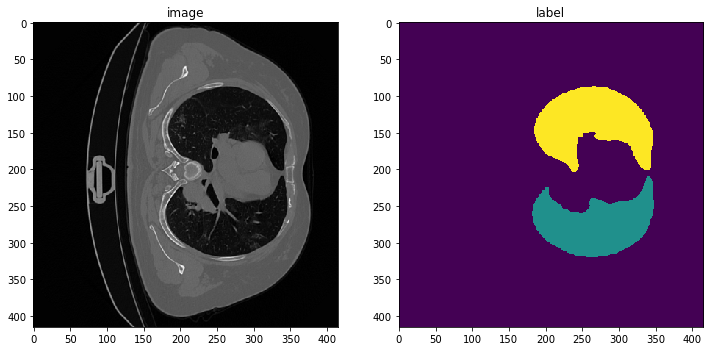

In [8]:
import matplotlib.pyplot as plt
check_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
check_loader = monai.data.DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 90], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 90])
plt.show()

In [3]:
import logging
import os
import shutil
import sys
import tempfile
import glob

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import CacheDataset, NiftiDataset, create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, NormalizeIntensityd, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandSpatialCropd, RandAffined, Spacingd, Orientationd, ToTensord
from monai.visualize import plot_2d_or_3d_image

from torch import nn
monai.config.print_config()

from typing import Optional, Union

import warnings

from monai.networks import one_hot
from monai.utils import MetricReduction

class CrossentropyND(torch.nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)
    
class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.):
        """
        """
        super(SoftDiceLoss, self).__init__()

        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn, _ = get_tp_fp_fn_tn(x, y, axes, loss_mask, False)

        nominator = 2 * tp + self.smooth
        denominator = 2 * tp + fp + fn + self.smooth

        dc = nominator / denominator

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc
    
def get_tp_fp_fn_tn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes: can be (, ) = no summation
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot
    tn = (1 - net_output) * (1 - y_onehot)

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)
        tn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2
        tn = tn ** 2

    if len(axes) > 0:
        tp = sum_tensor(tp, axes, keepdim=False)
        fp = sum_tensor(fp, axes, keepdim=False)
        fn = sum_tensor(fn, axes, keepdim=False)
        tn = sum_tensor(tn, axes, keepdim=False)

    return tp, fp, fn, tn

class DC_and_CE_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, ce_kwargs, aggregate="sum", square_dice=False, weight_ce=1, weight_dice=1):
        """
        CAREFUL. Weights for CE and Dice do not need to sum to one. You can set whatever you want.
        :param soft_dice_kwargs:
        :param ce_kwargs:
        :param aggregate:
        :param square_dice:
        :param weight_ce:
        :param weight_dice:
        """
        super(DC_and_CE_loss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.aggregate = aggregate
        self.ce = CrossentropyND(**ce_kwargs)
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target) if self.weight_dice != 0 else 0
        ce_loss = self.ce(net_output, target) if self.weight_ce != 0 else 0
        if self.aggregate == "sum":
            result = self.weight_ce * ce_loss + self.weight_dice * dc_loss
        else:
            raise NotImplementedError("nah son") # reserved for other stuff (later)
        return result

def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp




# Main function
def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)
    print('zenodo 4-fold cross-validation')
    
    # Supervised learning data for training and validation
    data_dir = '/home/marafath/scratch/zenodo'
    mask_dir = '/home/marafath/scratch/zenodo/mask'
    
    train_images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
    train_labels = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))
    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
    
    for i in range(0,4):
        if i == 0:
            train_files, val_files = data_dicts[0:15], data_dicts[15:20]
        elif i == 1:
            train_files = data_dicts[0:10] + data_dicts[15:20]
            val_files = data_dicts[10:15]
        elif i == 2:
            train_files = data_dicts[0:5] + data_dicts[10:20]
            val_files = data_dicts[5:10]
        elif i == 3:
            train_files, val_files = data_dicts[5:20], data_dicts[0:5]


        # Defining Transform
        train_transforms = Compose([
            LoadNiftid(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            NormalizeIntensityd(keys=['image'], nonzero=False, channel_wise=False),
            Spacingd(keys=['image', 'label'], pixdim=(1., 1., 2.0), mode=('bilinear', 'nearest')),
            ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['image', 'label'], source_key='image'),
            RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                               neg=1, num_samples=4, image_key='image', image_threshold=0),
            ToTensord(keys=['image', 'label'])
        ])
        val_transforms = Compose([
            LoadNiftid(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            NormalizeIntensityd(keys=['image'], nonzero=False, channel_wise=False),
            Spacingd(keys=['image', 'label'], pixdim=(1., 1., 2.0), mode=('bilinear', 'nearest')),
            ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
            ToTensord(keys=['image', 'label'])
        ])

        #train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
        train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(
                train_ds,
                batch_size=1,
                shuffle=True,
                num_workers=4,
                collate_fn=list_data_collate,
                pin_memory=torch.cuda.is_available()
        )

        #val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
        val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
        val_loader = DataLoader(
                val_ds, 
                batch_size=1, 
                num_workers=4, 
                collate_fn=list_data_collate,
                pin_memory=torch.cuda.is_available()
        )

        dice_metric = DiceMetric(include_background=False,to_onehot_y=True,mutually_exclusive = True,sigmoid=False,reduction="mean")

        # Defining model and hyperparameters
        device = torch.device("cuda:0")
        model = monai.networks.nets.UNet(
            dimensions=3,
            in_channels=1,
            out_channels=3,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        ).to(device)

        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        loss_function = DC_and_CE_loss({'smooth': 1e-5, 'do_bg': False}, {})
        optimizer = torch.optim.Adam(model.parameters(), 1e-3)

        # start a typical PyTorch training
        val_interval = 1
        best_metric = -1
        best_metric_epoch = -1
        epoch_loss_values = list()
        metric_values = list()
        writer = SummaryWriter()
        epc = 100
        for epoch in range(epc):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{epc}")
            model.train()
            epoch_loss = 0
            step = 0
            for batch_data in train_loader:
                step += 1
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                epoch_len = len(train_ds) // train_loader.batch_size
                print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
                writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    metric_sum = 0.0
                    metric_count = 0
                    val_images = None
                    val_labels = None
                    val_outputs = None
                    for val_data in val_loader:
                        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                        roi_size = (128, 128, 96)
                        sw_batch_size = 4
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                        value = dice_metric(y_pred=val_outputs, y=val_labels)
                        metric_count += len(value)
                        metric_sum += value.item() * len(value)
                    metric = metric_sum / metric_count
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), '/home/marafath/scratch/saved_models/zenodo_{}.pth'.format(i+1))
                        print("saved new best metric model")
                    print(
                        "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                            epoch + 1, metric, best_metric, best_metric_epoch
                        )
                    )
                    writer.add_scalar("val_mean_dice", metric, epoch + 1)
                    # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                    plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                    plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                    plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
                
    print('train completed, best_metric: {:.4f} at epoch: {}'.format(best_metric, best_metric_epoch))
    writer.close()

if __name__ == '__main__':
    main()

MONAI version: 0.1.0+715.gf777a25.dirty
Python version: 3.7.4 (default, Jul 18 2019, 19:34:02)  [GCC 5.4.0]
Numpy version: 1.18.1
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.16.2
Pillow version: 7.1.0
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

MONAI version: 0.1.0+715.gf777a25.dirty
Python version: 3.7.4 (default, Jul 18 2019, 19:34:02)  [GCC 5.4.0]
Numpy version: 1.18.1
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.16.2
Pillow version: 7.1.0
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0
ITK version: NOT IN

KeyboardInterrupt: 